<a name="notebook_4"></a>


# 4 - Inference on POI in presence of a nuissance parameter: Pivots, and Mapping Confidence Sets to Confidence Intervals

## Pivotal Likelihood-Free Inference for Count Data in Particle Physics

Ali Al Kadhim and Harrison B. Prosper <br>
Department of Physics, Florida State University <br>

### please see the other [noteboooks](https://alialkadhim.github.io/LFI_HEP), especially notebooks 2,3,5.

In [37]:

import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

try:
    import optuna
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
# import sympy as sy
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this
import ipywidgets as wid; wid.HTMLMath('$\LaTeX$')
# from compute_coverage import *

HTMLMath(value='$\\LaTeX$')

In [38]:
try:
    LFI_PIVOT_BASE = os.environ['LFI_PIVOT_BASE']
    print('BASE directoy properly set = ', LFI_PIVOT_BASE)
    # utils_dir = os.path.join(LFI_PIVOT_BASE, 'utils')
    # sys.path.append(utils_dir)
    # import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    # from utils import *
except Exception:
    print("""BASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/LFI_HEP


# 4.1 Background on all the ways to calculate confidence intervals and relation to ALFFI


The objective now is to derive confidence intervals or limits for the parameter of interest $\mu$. What makes this challenging is the presence of the **nuissance parameter** $\nu$, which is a parameter whose value is not known precisely, but affects the inference on the parameter of interest $\mu$.  

> Basu (1977) also discusses the problem nicely: basically, if $\theta \leftrightarrow P_{\theta}$ i.e. if $\theta$ maps oone-to-one onto $P_\theta$ where $P_{\theta}$ is a probability measure on the space of observation (i.e. $P_{\theta} = L(x|\theta)$ in modern language), then there is no problem and the inference on $\theta$ is good. However, in most cases, we have to work with a (total) likelihood that is indexed as $L(X| \theta \in \Theta, \phi \in \Phi)$ where $\theta$, the POI, is a member of parameter space $\Theta$ and $\phi$ is an additional unknown parameter in family $\Phi$.




In dealing with statistical inference it is important to deal with nuissance parameters (i.e. systematics, e.g. jet energy scale, or any other parameters dealing with experiment or theory that are not known exactly) because we want to isolate to what extent your result is sensetive to a particular nuissance parameter (as opposed to, say, statistical fluctuations). 

Bayesian and Frequentist methods alike treat nuissance parameters in a similary way: they **try to** partition the likelihood into components representing information on the parameter of interest, and into components representing the nuissance parameter(s). In HEP, we can have many nuissance parameters that repressents our ignorance of certain quantities, which are called "systematic uncertainties".


Broadly speaking, The standard procedure for removal of nuissance parameters, as discussed above is **Bayesian marginalization**. In the Bayesian approach, nuissance parameters are assigned prior probabilities $\pi(\nu) d \nu$ and are integrated out in order to arrive at the posterior for $\mu$ : 

$$L(\mu) = \int L(\mu,\nu) \pi (\nu) d \nu. $$ 

However, this introduces a fair bit of subjectivity into the problem through the choice of the prior.

<!--$$ L(\theta) = P(x|\theta) = \int P(x \mid \theta, \nu) \pi (\nu) d \nu$$-->

where the uncertainty in the nuissance parameter is characterized by a prior PDF $\pi(\nu)$ (and $p(x|\theta)$ is sometimes called a marginal model of the data and POI, which is a 1-D posterior for he POI)

Frequentist methods deal with nuissance parameters by profiling them the likelihood in order to arrive at their MLEs.
i.e. integrate out the dependence of the nuissance parameter in the posterior to arrive at the posterior marginal distribution of the parameter of interest. This is known as **Frequentist profiling**:

$$L_{\text{profile}}(\mu) = L(\mu, \hat{\hat{\nu}}(\mu) ),  $$

where $\hat{\hat{\nu}}$ means the profiled values (values that maximize $L$) for a specified $\mu$.
---

### This means that in order to derive **confidence intervals**, we can either:

1. Follow the **Neyman construction** (as was done in the [first notebook](#notebook_1) )

> Neyman has shown a method for calculation of confidence intervals that guarantees coverage via a method usually referred to as "Neyman Construction". One problem with Neyman construction, however, is that with multi-parameter problems, it is very difficult to construct intervals that guarantee coverage (that is, they have coverage of at least $1-\alpha$). The reason for this difficulty is that one has to repeat this construction for each point in the space of nuissance parameters, by treating the nuissance parameter as fixed, and constructing the interval for the POI. 

2. **Construct Bayesian ("credible") intervals** $[\mu^{lo}, \mu^{up}]$ by solving for $\mu^{lo}, \mu^{up}$ in the equation (this process is called marginalization):

$$ CL = \int_{\mu^{low} }^{\mu^{up}} \text{posterior}(D | \mu)\  d \mu = \int_{\mu^{low} }^{\mu^{up}} \mathcal{L} (D;\mu) \ \text{prior}(\mu)\ d \mu$$

where $CL=1-\alpha$ and $\int_{\mu^{low} }^{\mu^{up}} \text{posterior}(D | \mu)\ d \mu=\mathbb{P} (\mu \in [\mu^{low}, \mu^{up}] )$
Which means the confidence interval is solved from the limits of integration above.



In our probelm (see more below) this ammounts to solving


$$ \int_{\mu^{lo}}^{\mu^{up}} \int_{\nu^{lo}}^{\nu^{up}} \mathcal{L}(D; \mu, \nu) \ \pi(\mu) \ \pi(\nu) \  d \mu \ d \nu = 1-\alpha$$


> As discussed in the first notebook, there is a big instinsic problem in the choice this prior (both for subjective priors and non-subjective, e.g. "reference priors"). Furthermore, it is a big computational and technical challenge to solve the integral, which is often calculated by MC, but becomes exponentially harder to compute as the number of nuissance parameters increases.

3. Using the likelihood ratio ($\lambda_{\text{NP}}$).

> We follow this procedure, discussed at length in this work, in constructing


Each of these methods has many problems, discussed throughout this jupyterbook, and they all don't guarantee coverage for multi-parameter problems with nuissance parameters. Guaranteeing coverage for such problems for POIs and nuissance parameters remains a topic of statistical research.









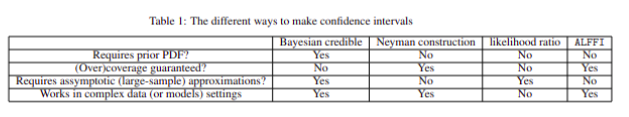

In [18]:
display(Image(os.path.join(LFI_PIVOT_BASE,'images','ways_to_make_CIs_screenshot.png')))

# 4.2: Mapping Confidence Regions (Sets) to Confidence intervals

We would like to extend map confidence region (or set) $R(D)$ to univariate confidence interval for a particular parameter. What we currently have, is that 
$$\mathbb{P} [ R(D) \text{ will cover the true }\{\mu,\nu\} \text{pair} ] \ge 1-\alpha $$

Or, in other words,

$$\mathbb{P} \left( (\mu_0,\nu_0) \in R(D) \right) = \mathbb{P}\left( \mu_0 \in [\mu^{lo},\mu^{up} ] \text{ and } \nu_0 \in [\nu^{lo},\nu^{up} ] \right) \ge 1-\alpha $$




We would like to map the statement in Eq 5 to a confidence interval on an individual parameter
$$\mathbb{P}\left( \mu_0 \in [\mu^{lo},\mu^{up} ] \right) \ge 1-\alpha $$


> Aside: it is interesting to note that the value $\theta_0$ is fixed and unknown while the variables $\{\mu^{lo},\mu^{up} \}$ is a set a random (like a random variable) set of the data $\mathcal{D}$. One other benefit of LFI is that we can always generate synthetic data, whereas in traditional ML, the training dataset is fixed.


i.e. map The confidence region to a coverage probability of an individual parameter, say parameter of interest

$$\mathbb{CR}({\mu,\nu}) \rightarrow \mathbb{CPI}(\mu)$$






## 4.3: Connection to Gaussian Distributed Measurements

### 4.3.1: Gaussian 1D

Suppose we have a univariate random variable $X$ (that is, $x \in \mathbb{R}^1$) that is sampled from a normal distribution $X \sim \mathcal{N}(\mu, \sigma^2)$ The PDF of this RV (which is usually an estimate of the true mean) is parameterized by $\mu, \sigma^2$

$$p_X (x) = p(x) = p(x;\mu, \sigma^2) = \frac{1}{\sqrt{2\pi} \sigma} e^{\frac{- (x-\mu)^2 }{2 \sigma^2 }}$$

Suppose $\sigma^2$ is known and one would like to make inference on $\mu_{\text{true}}$. The probability that this RV falls within $\pm \delta$ of  $\mu_{\text{true}}$
is

$$\begin{aligned}
\mathbb{P}(x \in [\mu_{\text{true}} - \delta,\mu_{\text{true}} + \delta]  &= \frac{1}{\sqrt{2 \pi} \sigma} \int_{\mu_{\text{true}}-\delta}^{\mu+\delta} e^{-(x-\mu)^2  2 \sigma^2} d x \\
& =\operatorname{erf}\left(\frac{\delta}{\sqrt{2} \sigma}\right) \\
&= 2 \Phi\left(\frac{\delta}{\sigma}\right)-1,
\end{aligned}$$

Where $\Phi(x)$ is the CDF of a standard normal RV (a standard normal means a RV sampled from $\mathcal{N}(\mu=0, \sigma^2=1)$. 
$$ \Phi(x)\equiv\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^x e^{-t^2 / 2} d t$$

and $\delta=z\sigma$ where $z$ is an integer and $\sigma$ is the standard deviation, so that $\delta$ is the number of standard deviations. The equation above says that the probability that $x$ will fall within $\pm \delta$ of the true value of $\mu$ is
$$ 2 \Phi \left( \frac{\delta}{\sigma} \right) -1$$
If we set this probability to the confidence level, and plug in for $\delta$ we have

$$2 \Phi \left( \frac{z \sigma}{\sigma} \right) -1 = 1-\alpha \tag{7}$$

Example: Eq 7 means that if we want the $2\sigma$ inteval for $\theta$, we have
$$ \mathbb{P} \left( \theta \in [\mu_{\text{true}} -2\sigma, \mu_{\text{true}} +2\sigma] \right) =  2 \Phi \left( 2 \right) -1 = 1-\alpha $$

And, using the $\chi^2$ distribution approximation, 

$$ \mathbb{P} \left( \theta \in [\mu_{\text{true}} -2\sigma, \mu_{\text{true}} +2\sigma] \right) =  2 \Phi \left( 2 \right) -1 = 1-\alpha  = F(\chi^2_n)$$

(Therefore, by setting the number of standard deviations, we are setting the $1-\alpha$ level, whose value can be found either by the CDF of the gaussian or of the $\chi^2$, where in both cases these values are tabulated, so the results can be immediately attained for any Gaussian distrubtued value.

### 4.3.2: Multivariate normal


Recall that the if we have a multivariate normal random variable $Y \in \mathbb{R}^d$. Then $Y \sim \mathcal{N}(\mu, \sigma^2)$ if 

$$ p(y)=\frac{1}{(2 \pi)^{d / 2}|\Sigma|^{1 / 2}} \exp \left(-\frac{1}{2}(y-\mu)^T \Sigma^{-1}(y-\mu)\right)$$

For this multivariate distribution of size $p$ (which usually represents an estimates $\mathbf{y}=\widehat{\boldsymbol{\theta}}=\left(\widehat{\theta}_1, \ldots, \widehat{\theta}_p\right)$), the construction of the $p-$dimensional confidence set requires the full covriance matrix $\mathrm{K}_{X_i X_j}$. The covariance matrix $\text{Cov}(X_i X_j)$ is a matrix whose $(i,j)$ component is the covariance

$$\operatorname{cov}\left[X_i, X_j\right]=\mathbb{E}\left[\left(X_i-\mathbb{E}\left[X_i\right]\right)\left(X_j-\mathbb{E}\left[X_j\right]\right)\right]$$

Let $\mathbf{X}$ be a random vector, that is, a sequence of random variables $(X_1, ..., X_d)$. We say that each realization of $\mathbf{X}$ is an element in $\mathcal{R}^d$. Then

$$ \begin{equation}
\mathbb{E}[\mathbf{X}]:=\left(\begin{array}{c}
\mathbb{E}\left[X_1\right] \\
\mathbb{E}\left[X_2\right] \\
\vdots \\
\mathbb{E}\left[X_d\right]
\end{array}\right)=\left(\begin{array}{c}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_k
\end{array}\right)=: \boldsymbol{\mu}
\end{equation} $$

And the covariance matrix (by the definition above) is

$$ \begin{equation}
=\left(\begin{array}{ccc}
\mathbb{E}\left[\left(X_1-\mu_1\right)\left(X_1-\mu_1\right)\right] & \cdots & \mathbb{E}\left[\left(X_1-\mu_1\right)\left(X_k-\mu_k\right)\right] \\
\mathbb{E}\left[\left(X_2-\mu_2\right)\left(X_1-\mu_1\right)\right] & \cdots & \mathbb{E}\left[\left(X_2-\mu_2\right)\left(X_k-\mu_k\right)\right] \\
\vdots & \vdots & \vdots \\
\mathbb{E}\left[\left(X_d-\mu_d\right)\left(X_1-\mu_1\right)\right] & \cdots & \mathbb{E}\left[\left(X_d-\mu_k\right)\left(X_d-\mu_d\right)\right]
\end{array}\right)
\end{equation}
$$




### 4.4: Bivariate normal: Confidence ellipses

Let $\vec{\theta}$ be a bivariate normal variable

$$\Theta \sim \mathcal{N}_2 (\vec{\mu},\Sigma) = [\theta_1.\theta_2] \equiv \vec{\theta}$$

That is, its PDF is given by

$$ p(\vec{\theta})=\frac{1}{|2 \pi \Sigma|^{1 / 2}} \exp {\left(-\frac{1}{2}(\vec{\theta}-\vec{\mu})^T \Sigma^{-1}(\vec{\theta}-\vec{\mu})\right)} $$

The confidence region (or set) for a bivariate normal random variable, that is, is determined by a *confidence ellipse*. A confidence ellipse is defined to be the set of $\vec{\theta}$ such that the PDF is equal to some constant $c$. And this means that the argument in the exponential is constant, that is 

$$\left(-\frac{1}{2}(\vec{\theta}-\mu)^T \Sigma^{-1}(\vec{\theta}-\mu)\right) = c.$$


That is, the confidence ellipse contours represent lines of constant density. We will show below that drawing lines of constant density results in drawing ellipses. 

### 4.5: Aside: a quick review of ellipses

The equation of an ellipse, cenntered at $(x,y)=(0,0)$ is

$$\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1 $$

Where the length of the major axis is $a$ and the length of the minor axis is $b$ if $a>b$. 


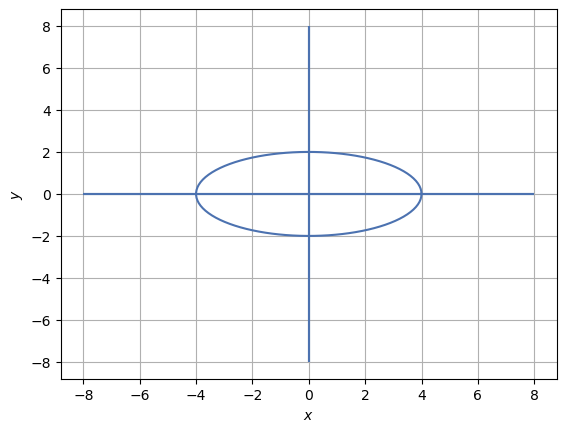

In [62]:
a, b = 4, 2
# of course, the sllipse can be prameterized as 
# x = mu_1 + a cos(t), y = mu_2 + b sin(t)
# where (mu_1,mu_2) is the center of the ellipse
def ellipse(major_ax=a, semi_major_ax=b, mu1=0, mu2=0):
    import math
    t= np.linspace(0, 2* math.pi, 100) 
    plt.plot(mu1 + major_ax * np.cos(t), mu2 + b * np.sin(t))
    vlmin, vlmax = -8, 8
    hlmin, hlmax = -8, 8
    plt.vlines(x=0, ymin=vlmin, ymax=vlmax); 
    plt.hlines(y=0, xmin=hlmin, xmax=hlmax)
    plt.vlines(x=mu1, ymin=vlmin, ymax=vlmax); 
    plt.hlines(y=mu2, xmin=hlmin, xmax=hlmax)
    plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
    plt.grid()
    plt.show()

ellipse()

To see how 

$$(\vec{\theta}-\mu)^T \Sigma^{-1}(\vec{\theta}-\mu) = c \tag{7}$$

is equivalent to an equation of an ellipse

$$ \frac{x^2}{a^2} + \frac{y^2}{b^2}=1 \tag{8} $$

Note the following: let 

$$
\vec{\theta}=\left[\begin{array}{l}
x \\
y
\end{array}\right]
$$
and 

$$ \begin{equation}
A=\left(\begin{array}{ll}
a^2 & 0 \\
0 & b^2
\end{array}\right)
\end{equation}$$

Then

$$ \vec{\theta}^T A^{-1} \vec{\theta} = \frac{x^2}{a^2} + \frac{y^2}{b^2} $$

And so Eq. 8 is equivlent to

$$ \vec{\theta}^T A^{-1} \vec{\theta} =1. \tag{9}$$

Now, uppose that the ellipse is not centered around the origin, say that it's centered at $(\mu_1, \mu_2)$, then we can just subtract the vector of the center of the ellipse $\vec{\mu}$ from Eq. 9:

$$ (\vec{\theta}-\vec{\mu})^T A^{-1} (\vec{\theta}-\vec{\mu}) =1 \tag{10}$$


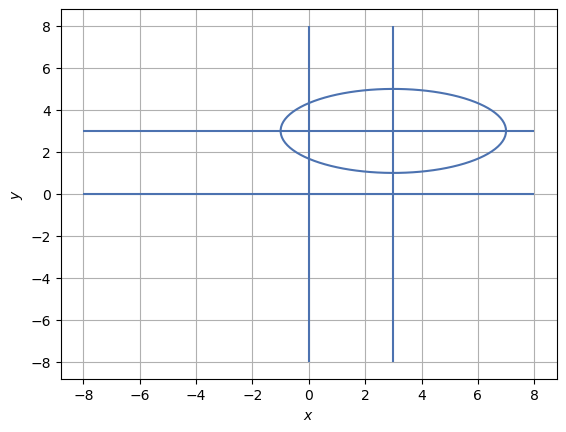

In [63]:
ellipse(mu1=3, mu2=3)

Now, $\Sigma$ in Eq 8 might not be a diagonal matrix, as $A$ is in Eq. 10. The effect of a non-diagonal matrix is to rotate the ellipse, so that rather than the major/minor axces being parallel to the coordinate axes, they would be parallel to some other axes.

To see this, apply the spectral decomposition to $\Sigma$, that is

$$\Sigma = V \Lambda V^T$$

So Eq. 10 for $\Sigma$ becomes

$$ (\vec{\theta}-\vec{\mu})^T (V \Lambda V^T)^{-1} (\vec{\theta}-\vec{\mu}) =1. \tag{11}$$

Now, let $\vec{y}=V^T (\vec{\theta}-\vec{\mu})$. So, Eq. 11 becomes

$$ y^T \Lambda y = 1. \tag{12}$$

Now, Eq. 12 is the equation of a standard ellipse, so $\Lambda$ is now diagonal

$$ \begin{equation}
\Lambda=\left(\begin{array}{ll}
\lambda_1 & 0 \\
0 & \lambda_2
\end{array}\right)
\end{equation}. \tag{13}$$

So, Eq. 13 represents an equation of an ellipse centered at the origin with major axis $y_1$ and semi-major axis $y_2$, with lengths of major and semi-major axes being $\lambda_1$ and $\lambda_2$, respectively.

To convert $\vec{\theta}$ in terms of $\vec{y}$ , 

$$\vec{\theta}=V \vec{y} + \vec{\mu}$$

So that the ellipse is oriented along the two eigenvectors $v_1, v_2$ (as opposed to the original coordinate axes) and centered at $\vec{\mu}$.

### 4.6: Calculating the multivariate coverage, that is, the area (volume) of the ellipse (ellipsoid)

Let $ \Theta \sim \mathcal{N}_p (\vec{\mu}, \Sigma)$, then

$$ (\vec{\theta}-\vec{\mu})^T \Sigma^{-1} (\vec{\theta}-\vec{\mu}) \sim \chi^2_p $$

Therefore, the $(1-\alpha)$ confidence set for bivariate normal $\vec{\theta}$ is given by

$$ \mathbb{P} \left( (\vec{\theta} -\vec{\mu})^T \Sigma^{-1} (\vec{\theta}-\vec{\mu}) \le \chi^{2}_{2} (\alpha)  \right) = 1-\alpha, $$

where $\chi^2_2 (\alpha)$ is the upper (100$\alpha$)th percentile of the $\chi^2$ distribution with 2 degrees of freedom. $1-\alpha$ is the probability (or confidence level) that the value of the random vector $\vec{\theta}$ will be inside the ellipse.

For example, take $\alpha=0.05$, so that $\chi^2_2 (0.05) = 5.99$, then, the $(1-\alpha)$, or the 95 %, condidence ellopse is defined by

$$ \mathbb{P} \left( (\vec{\theta} -\vec{\mu})^T \Sigma^{-1} (\vec{\theta}-\vec{\mu}) \le 5.99  \right) = 0.95. \tag{13}$$



So, say we want the 95% confidence ellipse, that is, the argument of Eq. 13 is 

$$ \begin{equation}
\left[\theta_1-\mu_1 \theta_2-\mu_2\right] \Sigma^{-1}\left[\begin{array}{l}
\theta_1-\mu_1 \\
\theta_2-\mu_2
\end{array}\right] \leq \chi_2^2(0.05)
\end{equation}$$

Recall

$$ \begin{equation}
\Sigma=\left[\begin{array}{ll}
\sigma_{11} & \sigma_{12} \\
\sigma_{21} & \sigma_{22}
\end{array}\right]
\end{equation}$$


Using the above results for writing  $\Sigma=V \Lambda V^T$, we have

$$ \begin{equation}
\Lambda=\left(\begin{array}{ll}
\lambda_1 & 0 \\
0 & \lambda_2
\end{array}\right)
\end{equation}.$$

$$ \begin{equation}
\left[\begin{array}{ll}
\theta_1-\mu_1 & \theta_2-\mu_2
\end{array}\right] V \Lambda^{-1} V^{T}\left[\begin{array}{l}
\theta_1-\mu_1 \\
\theta_2-\mu_2
\end{array}\right] \leq \chi_2^2(0.05)
\end{equation}$$

Denote

$$ \begin{equation}
\left[\begin{array}{l}
v_1 \\
v_2
\end{array}\right]=\Lambda^{-1}\left[\begin{array}{l}
\theta_1-\mu_1 \\
\theta_2-\mu_2
\end{array}\right]
\end{equation}
$$

So the confidence ellipse will be given by

$$ \begin{equation}
\frac{v_1^2}{\chi_2^2(0.05) \lambda_1}+\frac{v_2^2}{\chi_2^2(0.05) \lambda_2} \leq 1
\end{equation}$$

Where the eigenvalues are

$$\begin{equation}
\begin{array}{l}
\lambda_1=\frac{1}{2}\left[\sigma_{11}+\sigma_{22}+\sqrt{\left(\sigma_{11}-\sigma_{22}\right)^2+4 \sigma_{11} \sigma_{22} \rho^2}\right] \\
\lambda_2=\frac{1}{2}\left[\sigma_{11}+\sigma_{22}-\sqrt{\left(\sigma_{11}-\sigma_{22}\right)^2+4 \sigma_{11} \sigma_{22} \rho^2}\right]
\end{array}
\end{equation} $$

In [ ]:
def Display(filename):
    display(Image(os.path.join(LFI_PIVOT_BASE,'images',filename)))

Display()

### Toy experiments: Sample bivariate normal

Let's take $\mathbf{\theta}=(\mu,\nu)$ sampled from a bivariate normal with 

$$
\mu=\left[\begin{array}{l}
2 \\
2
\end{array}\right]
$$

and 

$$
\Sigma=\text{Cov}(\mu,\nu)=
\left[\begin{array}{cc}
1 & -0.8 \\
-0.8 & 1
\end{array}\right]
$$

That is, $\mathbf{\theta} $ is a $2\times 1$ vector $\mathbf{\theta} \sim \mathcal{N}_2(\mu, \Sigma)$. And select the 68% confidence set.

[[ 2.60882699  1.39898454]
 [-0.64123783  3.29990794]
 [ 1.18221868  3.21031479]
 ...
 [ 4.61586531  0.68544702]
 [-0.34048567  3.7540929 ]
 [ 2.36199034  1.79477032]]


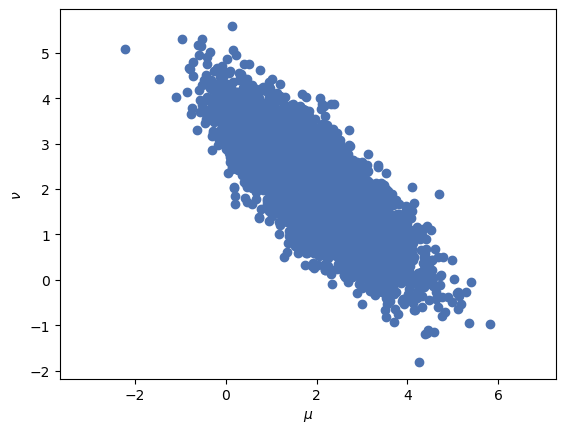

In [36]:
from scipy.stats import multivariate_normal
mu=np.array([2,2])
cov = np.array([[1,-0.8],[-0.8,1]])
plt.subplot(1,1,1)
bivariate = multivariate_normal(cov=cov, mean=mu)
samples=bivariate.rvs(size=5000)
print(samples)
plt.plot(samples[:,0], samples[:,1], 'o')
plt.xlabel(r'$\mu$'); plt.ylabel(r'$\nu$'); plt.axis('equal'); plt.show()

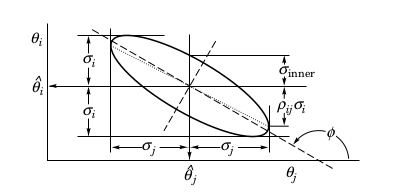

In [19]:
display(Image(os.path.join(LFI_PIVOT_BASE,'images','Gaussian_conf_ellipse.png')))


For Gaussian distributed parameters, e.g. bivariate normal distribution, we can say something about the cconfidence interval of one of the parameters irrespective and independetly of the other parameter. 


For the 2D case, i.e. say you have a pair of bivariate normally-distributed estimates $\mathbf{\theta}=(\theta_1,\theta_2)$ the construction of the confidence ellipse requires the covariance matrix of the estimates 

$$\text{Cov}[\theta_i,\theta_j]$$.

We then have an ellipse, and hence we can plot every point on that ellipse which coreresponds to our critical region. We can then map this confidence ellipse to the confidence interval of each parameter by

$$\tan{ 2 \phi} = \frac{2 \rho_{ij} \sigma_i \sigma_j }{ \sigma_j^2 - \sigma_i^2}$$ 

Where $\rho_{ij} = \frac{\text{Cov}[\theta_i,\theta_j]}{\sigma_i, \sigma_j}$




See Refs [1], [2] and [2] for the full perscription

 
The algorithm goes as follows:

1. One first determines the confidence level. (For example, if you want a 95% confidence ellipse, you use a critical value of 1.06 which correspends to 2 standard deviations from the mean of the normal distribution).

2.  one then calculates the eigenvectors and eigenvalues of the covariance matrix
3. Then calculate the two eigenvalues and eigenvectors of the covariance matrix
4. Calculate the angle of rotation for the ellipse using the eigenvectors. This angle is given by the arctangent of the ratio of the second eigenvector to the first.
5. Calculate the lengths of the semi-major and semi-minor axes of the ellipse. These are given by the square roots of the eigenvalues of the covariance matrix, scaled by the critical value for the desired level of confidence.

6. finally, plot the confidence ellipse centered at the mean of the distribution, rotated by the angle of rotation and  semi-major and semi-minor axes calculated in the steps above.






[1] Johnson, R. A., & Wichern, D. W. (2007). Applied multivariate statistical analysis (6th ed.). Pearson.

[2] Rencher, A. C. (2002). Methods of multivariate analysis (2nd ed.). Wiley.

[3] “Chew, V. (1966). Confidence, Prediction, and Tolerance Regions for the Multivariate Normal Distribution. Journal of the American Statistical Association, 61(315), 605. doi:10.2307/2282774 

## HEP Signal-Background Problem Statement

In particle physics, the most important experiment is a counting experiment, represented by a Poisson probability model.Suppose we have a count experiment, we we observe in each bin (or channel) $k$ a count $n_k$. Given $N$ total channels, the probability of obtaining the observed result is given by the Poisson

$$ L(\theta,\nu)= \prod_{k=1}^{N} \frac{e^{-(\epsilon_k \sigma + b_k)} (\epsilon_k \sigma + b_k)^{n_k}}{n_k !} $$

Where $\sigma$, the cross section (**the parameter of interest**), $b_k$ is expected background for the $k$th channel (in this context, it is **the nuissance parameter**, which is a parameter that is not unkown precisely, typically constrained in a control measurement).In HEP, $\nu$ can be related to the physics (theory) or the experimental aparatus/detector. $\epsilon_k$ is the "acceptance parameter", for the $k$th channel, which is typically a product of the detector efficiency, branching fraction, and luminosity.


This is the prototype of many statistical models in astronomy and particle physics in which data are binned and the count in each bin consist a priori of the sum of counts from signal and background. Written in terms of the simplified 2-parameter model, the expected count in each bin $k$ takes the form

\begin{equation}
    n_{expected}=\theta+\nu
\end{equation}

Where $n_{expected}$ is the expected signal count, $\theta$ is the unknown mean count, which is the parameter of interest (the cross section), and $\nu$ is the background unknown mean count, which is the nuissance parameter. In other words,  the total number of evented, $n_{expected}$, in a single bin is sampled from a Poisson with mean with mean $\epsilon \sigma + b$.  



The joint likelihood can then be constructed as

$$\begin{align}
    \mathcal{L} (D ; \mu, \nu) & = \frac{(\mu + \nu)^N \exp(-(\mu + \nu))}{N!} \,\frac{\nu^M\exp(-\nu)}{M!},
\end{align}$$

Note that this is different than the profiled likelihood over $\nu$
$$
\mathcal{L}_{\text{prof}}(D; \mu) \equiv \frac{e^{-(\mu+\hat{\nu})} (\mu+\hat{\nu})^N }{N !} \ \frac{e^{-\hat{\nu}} \hat{\nu}^M}{M !}.
$$


Notice that the likelihood also depends on nuissnace parameter $\nu$, which we don't know precisely. Suppose then, that instead of measuring everying all at once, we control our measurement a bit more, such that we divide the space into a "control measurement", where we are sure that the signal doesn't occor (e.g. by selecting a region of phase space that we are sure a particular event doesnt happen from physics), and a "signal region", in which both signal and background can occur. the conditional probability of observing $N$ signal counts and $M$ background counts (in a control measurement which is a single Poisson value) in a *single channel or bin* is given by

$$
    P(N, M \mid \mu, \nu)= \mathcal{L} (D ; \mu, \nu) =  L(\mu, \nu) =  \frac{e^{-(\mu+v)}(\theta+v)^{N}}{N !}} \frac{e^{-v} v^{M}}{M !}
    \label{prob_model}
$$


where, once the counts $n$ and $m$ have been observed becomes the likelihood $L(\theta,\nu)$. $L(\theta,\nu)$ could be viewed as a product of the main measurement where signal events ($s$) could be present, and a control measurement where only background events ($b$) exist, which helps us constrain the nuissance parameters. 

This factorization of $L(\mu, \nu)$ is called a controlled measurement, e.g. $ L(\mu n_{\text{signal}} + b(\nu)) $.

$$\mathcal{L}(D;\mu,\nu) = \mathcal{L}_{s+b}(\mu,\nu) \mathcal{L} _b(\nu)$$

$\mathcal{L}_{s+b}(\mu,\nu)=\frac{e^{-(\mu+\nu)}(\mu+\nu)^{N}}{N !} $ is called the signal+background region and $\mathcal{L} _b(\nu)=\frac{e^{-v} v^{M}}{M !}$ is called the background region.




If you're familiar with using "strength parameter" $\mu$, 

$$\mu \equiv \frac{\text{Lum.} \sigma_{\text{observed}} (\theta)}{\text{Lum.} \sigma_{\text{expected}} (\theta)},$$ 

where $\theta$ is the parameter of interest (such as $m_\text{Higgs}$), and "expected" means expected by the SM, of course.




then $L_{s+b}$ corresponds to having $\mu=1$ and $L_b$ corresponds to $\mu=0$ (backround-only, i.e. control, region).


The likelihood function (the compatibility of a hypothesis given a data set) contains all the information from the experiment that is relevent to inference for the parameters (also known as the *likelihood principle*). The likelihood function is defined only upto an arbitrary constant, and so only ratios of likelihoods containing different values of the parameters are meaningful.


$$\begin{align}
    \mathcal{L} (D ; \hat{\mu}, \hat{\nu}) & = \frac{(\hat{\mu} + \hat{\nu})^N \exp(-(\hat{\mu} + \hat{\nu}))}{N!} \,\frac{\hat{\nu}^M\exp(-\nu)}{M!},
\end{align},$$
where 
$$
\begin{equation}
     \hat{\mu} =\left\{
    \begin{array}{ll}
        N-M & \text{ if } \quad  N>M \\
        0 & \quad \textrm{ otherwise.}
    \end{array}
    \right. 
\end{equation}
$$
and
$$
\begin{equation}
     \hat{\nu} =\left\{
    \begin{array}{ll}
        M & \text{ if } \quad  \hat{\mu} = N - M \\
        (M+N)/2 & \quad \textrm{ otherwise.}
    \end{array}
    \right. 
\end{equation}
$$


In this study we adopt LFI with robust frequentest critical value estimation. We generate data comprising the quadruplets $\{\mu_i, \nu_i, N_i, M_i, Z_i \}$ where 



$$
\begin{align}
\mu & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
\end{align}
$$


$$
\left\{
\begin{align}
n & \sim \textrm{poisson}(\mu + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
\end{align}
\right\} \rightarrow \lambda_\text{gen}(n, m \mid \mu,\nu)
$$



$$
\left\{
\begin{align}
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \\
\end{align}
\right\} \rightarrow \lambda_D(N, M \mid \mu,\nu)
$$


$$
Z  = \mathbb{I}
\left[ \lambda_\text{gen}(n, m \mid \mu,\nu) \leq \lambda_D(N, M \mid \mu,\nu) \right], \tag{4}
$$

where the size of each of these samples is $B'$, $\mathbb{I}$ is the indicator function, and $\lambda_D (D, \mu) = \lambda_{NP}(N, M, \mu)$ is our chosen test statistic. In our new notation, eq. 4 is equivalent to

$$
Z  = \mathbb{I}
\left[ \lambda(\mathcal{D} \mid \mu,\nu) \leq \lambda^{\prime}(D \mid \mu,\nu) \right]
$$















### TODO 2: The pivotal $\lambda$ model in notebook 5 does the same thing (inference on $\mu$ independently of $\nu$ and seems to work, we should include it in this paper. The constraints could be done in other ways than just adding the term to the loss.

### TODO 3: sample $\mu \sim \pi(\mu)$ then $\nu(\mu) \sim \pi(\mu,\nu)$ which is equivalent to marginalizing $\pi(\nu)$.

### TODO 4: verify correct coverage of 1 parameter via Neyman.6th 


### TODO 4: use differentiable programming (as in jax or relaxxed) to get better results for these step functions during trainig, or use a kernel density estimate as a histogram alternative.

### TODO 5: apply it to high(er) dimensional parameter space



In [20]:
def mu_hat_(n,m):
    # np.where(condition, equals, otherwise_equals_to)
    mu_hat = np.where(n>m, n-m, 0)
    return mu_hat

def nu_hat_(mu_hat, n,m):
    def vectorize_int(scalar):
        return np.array(scalar, dtype=np.int)
    
    n, m, mu_hat = vectorize_int(n), vectorize_int(m), vectorize_int(mu_hat)
    nu_hat = np.where(mu_hat == n-m, m, (m+n)/2)
    return nu_hat

def L_theta_nu(n,m,theta,nu):
    p1 = st.poisson.pmf(n, theta+nu)
    p2 = st.poisson.pmf(m, nu)
    return p1*p2

def L_prof_global(n,m):
    # mu_hat = n-m
    mu_hat=mu_hat_(n,m)
    nu_hat = nu_hat_(mu_hat, n, m)

    p1=st.poisson.pmf(n, mu_hat+nu_hat)
    p2 = st.poisson.pmf(m, nu_hat)
    return p1*p2


$$ \begin{equation}
    \lambda(D, \theta)  = -2 \log \left[  \frac{\mathcal{L}(D ; \mu, \nu)}{\mathcal{L}(D ; \hat{\mu}, \hat{\nu})} \right],
    \label{Eq:lambda_on_off}
\end{equation}
$$

In [21]:
def lambda_test_2d(n,m, theta, nu):
    Ln= L_theta_nu(n,m,theta,nu)
    
    Ld= L_prof_global(n,m)
    eps=1e-14
    Ld=Ld+eps
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

chi2_exp_size=int(1e5)




In [22]:
def make_hist_2d_data_2d_inference(Bprime,
              mumin, mumax,
              numin, numax, 
                      N, M,
               nbinsmu, nbinsnu):

    mu = st.uniform.rvs(mumin, mumax, size=Bprime)
    nu = st.uniform.rvs(numin, numax, size=Bprime)
    n = st.poisson.rvs(mu + nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    #lambda_test_2d(n,m, mu, nu)
    Z = (lambda_test_2d(n,m, mu, nu)< 
         lambda_test_2d(N,M, mu, nu)).astype(np.int32)

    murange = (mumin, mumax)
    nurange = (numin, numax)
    # bins = binsize(Bprime)

    # Z-weighted histogram   (count the number of ones per bin)
    #mu will be on axis and nu on y axis
    y_mu_nu_w, bb_mu_edges, bb_nu_edges = np.histogram2d(mu, nu,
                          bins=(nbinsmu, nbinsnu), 
                          range=(murange, nurange), 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    y_mu_nu_uw, bb_mu_edges, bb_nu_edges = np.histogram2d(mu, nu,
                          bins=(nbinsmu, nbinsnu), 
                          range=(murange, nurange))
    eps=1e-15
    P_mu_nu =  y_mu_nu_w / (y_mu_nu_uw + eps)    
    #P_mu_nu approximates E[Z]
    return P_mu_nu, bb_mu_edges, bb_nu_edges

In [23]:
def plot_P_byhist_global_2d(fig, ax, Bprime,
              mumin, mumax,
              numin, numax, 
                      N, M,
               nbinsmu, nbinsnu,                    
                 save_plot=False):
    
    P_mu_nu, bb_mu_edges, bb_nu_edges = make_hist_2d_data_2d_inference(Bprime,
                  mumin, mumax,
                  numin, numax, 
                          N, M,
                   nbinsmu, nbinsnu)
    
    bin_centers_mu = (bb_mu_edges[1:]+bb_mu_edges[:-1])/2
    bin_centers_nu = (bb_nu_edges[1:]+bb_nu_edges[:-1])/2
    #WHOLE RANGE
    murange = (mumin, mumax)
    nurange = (numin, numax)
    # murange = (mumin, 10)
    # nurange = (numin, 10)
    ax.text(0.75,0.9, r'$\mu \in [%s,%s], \nu \in [%s,%s] $' % (str(mumin), str(mumax), str(numin),str(numax)), 
            horizontalalignment='center', verticalalignment='center',transform = ax.transAxes, fontsize=14)

    #Remember mu is on x and nu on y axes, so next line, each will be 2d
    MU, NU = np.meshgrid(bin_centers_mu, bin_centers_nu)
    
    MU_1d, NU_1d = MU.flatten(), NU.flatten()
    
    P_mu_nu = P_mu_nu.T
    P_mu_nu_byhist = P_mu_nu.flatten()
    
    ax.hist2d(MU_1d, NU_1d, bins=(nbinsmu, nbinsnu), 
               range=(murange, nurange),
               weights=P_mu_nu_byhist,
             cmap='Blues_r'
             )
    
    CLs=np.array([0.683,0.90,0.95])
    
    #To draw contours, the intensity (the p-value) must be 2D again
    P_mu_nu_byhist_2d = P_mu_nu_byhist.reshape(MU.shape)
    #for contours everything has to be 2d
    contours=ax.contour(MU, NU, P_mu_nu_byhist_2d,
              extent=(mumin, mumax, numin,numax),
              levels=CLs,
                        cmap='gist_earth_r'
                       )
    
#     #label the contours
    ax.clabel(contours, contours.levels, inline=True,
              fmt='%4.2f', 
              # colors='black',
              fontsize=18)
    ax.grid()
    ax.set_xlabel(r'$\mu$',fontsize=20); ax.set_ylabel(r'$\nu$',fontsize=20)
    ax.set_title(r'CS$(\mu,\nu)$ by $\mathbf{h}$: $N = %s$ , $M  = %s $ ' % (str(N),str(M)),fontsize=16)
    #add contour color bar
    # cbar = fig.colorbar(contours, ax=ax)
    ax.set_xlim(mumin, 10)
    ax.set_ylim(numin, 10)
    
    if save_plot == True:
        plt.savefig(os.path.join(os.environ['LFI_PIVOT_BASE'], 'images', 
                                 f"2D_Hist_mumin_{mumin}_mumax_{mumax}_numin_{numin}_numax_{numax}_2D_INFERENCE.png"))
    plt.tight_layout(); plt.show()

# Suppose we now make an observation, and remid yourself of definitions of our parameters

## Observed Data:

   * $N$ (observed counts for signal)
   * $M$ (observed counts for background)

## Parameters:

* $\mu$: parameter of interest, proportional to $\sigma$ in HEP (unknown signal mean)

* $\nu$: nuissance parameter (unknown background mean)

## Auxiliary (simulated) Data (simulated on-the-fly for each observation):

* $n$: expected signal count

* $m$: expected backround count



# Compute coverage for set and show it's satisfied. Then compute coverage for individual arameter $\theta$ with Neyman construction and show that it has nominal coverage

The idea was that in the case that $\theta =(\mu,\nu) \in \mathbb{R}^2$ we were able to get a confidence set for $(\mu,\nu)$ by using trained on $\lambda(D=\{N,M\})$ as data:

$$ X_{train} = \{ \mu_{\text{continuous}}, \nu_{\text{continuous}},\lambda(D=\{ N, M\} ) \}$$

$$t_{train} = Z_{(\theta,\nu)} $$

# ALFFI algorithm (see chapters 2 and 3 and `compute_coveragage.py`)


Recall that the idea of our ALFFI algorithm was

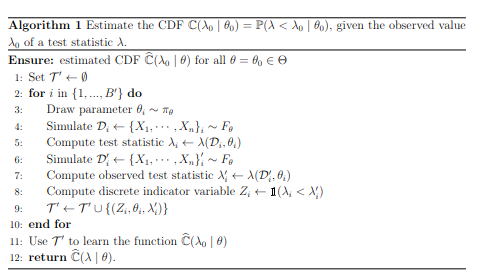

In [24]:
display(Image(os.path.join(LFI_PIVOT_BASE,'images','ALFFI_screenshot.png')))


# ALLFFI-CPI
We want to map from the confidence set (CS) of a $(\mu,\nu)$ point $CS(\mu,\nu)$ to a confidence interval (CI) of each individual parameter $CI(\mu), CI(\nu)$.

We want an input being the data $D$ and paramters $\theta$ generated on-the-fly, and the output being a CI on a single parameter. 

Another advantage of this approach is that it can be done in an arbitrary number of dimensions
 
The essential idea of the algorithm is to simply generate parameter points inside a particular confidence set, and take the minimum and maximum of those points as the upper and lower confidence intervals. Once you have the edges of a parameter at a particular CL, you can map the CS to the CI of that parameter at that CL.


Essentially, for a given CL, we have the contours in the region, so the edges of a parameter at the given CL can be found
$$\{ \vec{\mu}_{edge}^{CL}, \vec{\nu}_{edge}^{CL} \}=  \{ \vec{\mu}, \vec{\nu} : \hat{p} \le \tau \}$$

So that the intervals for a parameter at a given CL is simply
$$(\mu_{lo}, \mu_{up} ) = \left( min(\vec{\mu}_{edge}^{CL}), max(\vec{\mu}_{edge}^{CL}) \right)  $$

(idea another way we can do this is potentially to use $\lambda_{2D}$ to get the confidence set, but then use $\lambda_{1D}(\theta)$ to get the interval of $\theta$ within the set. 

So the NN is just a function of $\theta$ and a particular CL $\tau$ , and gives the coverage probability of an individual parameter $\mathbb{CPI}(\theta,\tau)$ . Once we have this function, we can say "I would like to have a confidence level on $\theta$ of 68%, and a way to achieve that is to construct a set whose coverage probability is 73%. 
 
 
Currently, we can't do that mapping because we only have the confidence region, i.e. a confidence interval on one parameter only in the existence of the confidence interval on the other parameter. We would like to do it globally, such that if we have confidence region, we can map that to confidence interval of other parameter regardless of the value of the other parameter. We use the Gaussian conffidence ellipse as a heuristic motivation of what we would like to do.



## ALFFI-CPI For inference using one single CL $\tau_1$


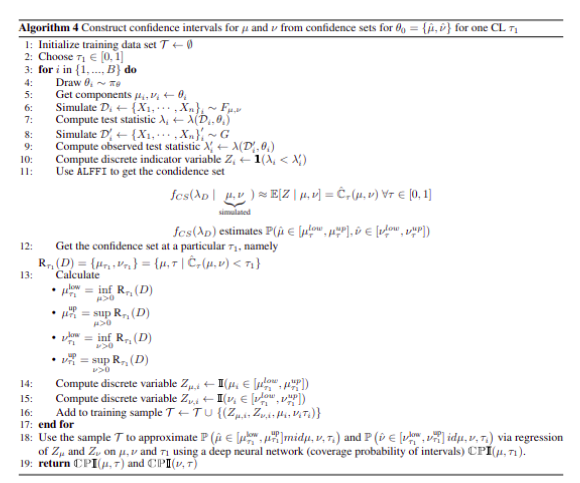

In [25]:
display(Image(os.path.join(LFI_PIVOT_BASE,'images','CPI_one_tau.png')))

In [26]:
mumin, mumax =  0, 20
numin, numax = 0, 20
Nmin, Nmax =  1,10
Mmin, Mmax =  1 , 10


In [29]:

def generate_data_CPI(Bprime,save_data=False):
    # $\theta \sim \pi_\theta$
    mu = st.uniform.rvs(mumin, mumax, size=Bprime)
    nu = st.uniform.rvs(numin, numax, size=Bprime)
    # $\mathca{D} \sim F_theta$
    n = st.poisson.rvs(mu+nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    # $D$
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    # Z_mu_nu
    lambda_mu_nu = lambda_test_2d(n,m, mu, nu)
    lambda_prime_mu_nu = lambda_test_2d(N,M, mu, nu)
    Z_mu_nu = (lambda_mu_nu <=lambda_prime_mu_nu ).astype(np.int32)
    data_CPI = {'mu': mu, 'nu': nu, 'n':n, 'm':m, 'N':N, 'M':M, 'Z_mu_nu':Z_mu_nu}
    
    data_CPI = pd.DataFrame.from_dict(data_CPI)
    return data_CPI
    
    

In [28]:
generate_data_CPI(Bprime=10,save_data=False)

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Check coverage of the set at several $\tau$ values and observe that for the 1D case, using our 2D algorithm the coverage is exact

## ALFFI-CPI for any (all) CLs $\tau$

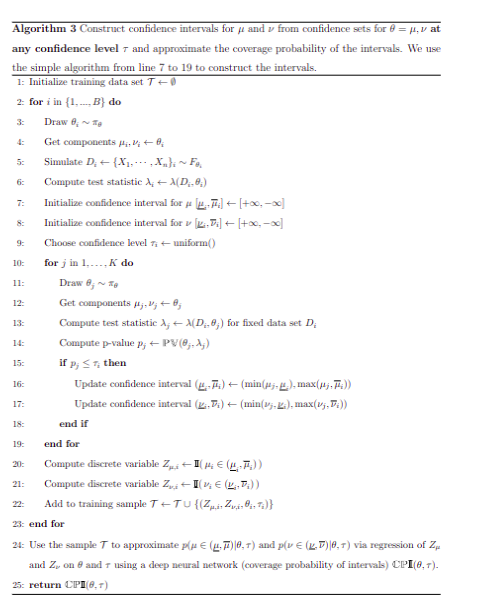

In [14]:
display(Image(os.path.join(LFI_PIVOT_BASE,'images','Confidence_set_any_tau_algorithm.png')))